In [52]:
# import modules
import os
#import sys

import pandas as pd
import numpy as np
#from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression


from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
# from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import ttest_ind
from scipy.stats import t


In [53]:
current_dir = os.getcwd()
current_dir
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")
current_dir = os.getcwd()
current_dir
#set current working directory to H:\VScode\March Group\March_Team_Project\
os.chdir("H:\\VScode\\March Group\\March_Team_Project\\")

You set a new current directory


In [54]:
# load Outputs/DashBoardData.zip'
merged_data = pd.read_csv("Outputs/DashBoardData.zip", compression='zip', low_memory=False)
# produce list of numeric and bool columns
numeric_columns = model_data.select_dtypes(include=['float64', 'int64', 'bool']).columns
# drop WS_Latitude, WS_Longitude from numeric_columns
numeric_columns = numeric_columns.drop(['WS_Latitude', 'WS_Longitude'])
# create a list of columns with skewness greater than 1
skewness = merged_data[numeric_columns].skew()
skewness = skewness[skewness > 1]
skewness

# Columns with high skewness
skewed_columns = skewness.index.tolist()

# Columns not in skewness
remaining_columns =[col for col in numeric_columns if col not in skewed_columns]


Transform data to standardise data ranges and correct skewness

In [55]:
# Use scikit learn to apply transformations to the data to standardise the data and correct skewness
merged_data_corrected=merged_data.copy()
# apply power transformer to columns with skewness greater than 1
power_transformer = PowerTransformer()
# apply standard scaler to all numeric columns
scaler = StandardScaler()

# apply power transformer to columns with skewed columns
skew_pipeline = make_pipeline(PowerTransformer(), StandardScaler())

# chain the power transformer and standard scaler into a pipeline
column_transformer = ColumnTransformer(transformers=[
    ('skewed', skew_pipeline, skewed_columns),
    ('scaled', StandardScaler(), remaining_columns)
])

pipeline = Pipeline(steps=[('column_transformer', column_transformer)])
merged_data_transformed = pipeline.fit_transform(merged_data_corrected)
merged_data_transformed_df = pd.DataFrame(merged_data_transformed)


Compare Correlation models

In [56]:
# Compare the correlation matrix before and after the transformations

# convert transformed data to a dataframe
merged_data_transformed_df = pd.DataFrame(merged_data_transformed)
# perform correlation matrix on transformed data
correlation_matrix_transformed_corr = merged_data_transformed_df.corr()
correlation_matrix_transformed_corr = correlation_matrix_transformed_corr.round(2)

# perform correlation matrix on original data
correlation_matrix_original = merged_data[numeric_columns].copy().corr()
correlation_matrix_original = correlation_matrix_original.round(2)

# check that correlation_matrix_transformed_corr and correlation_matrix_original are the same shape
if correlation_matrix_transformed_corr.shape != correlation_matrix_original.shape:
    print('The correlation matrices have different shapes')
    # print the shapes of the correlation matrices
    print(f'The shape of the correlation matrix for the transformed data is {correlation_matrix_transformed_corr.shape}')
    print(f'The shape of the correlation matrix for the original data is {correlation_matrix_original.shape}')
    print('The program will stop')
    # stop the program
    exit()
else:
    print('The correlation matrices have the same shape')

print("NaNs in original:", correlation_matrix_original.isna().sum().sum())
print("NaNs in transformed:", correlation_matrix_transformed_corr.isna().sum().sum())

# performa a statistical test to determine if the correlation matrices are significantly different
# calculate the difference between the two correlation matrices
# Flatten the correlation matrices to 1D arrays
original_corr_values = correlation_matrix_original.values.flatten()
transformed_corr_values = correlation_matrix_transformed_corr.values.flatten()

print("Original correlation min/max:", original_corr_values.min(), original_corr_values.max())
print("Transformed correlation min/max:", transformed_corr_values.min(), transformed_corr_values.max())

mask = ~np.isnan(original_corr_values) & ~np.isnan(transformed_corr_values)
original_clean = original_corr_values[mask]
transformed_clean = transformed_corr_values[mask]

print("Original clean correlation min/max:", original_clean.min(), original_clean.max())
print("Transformed clean correlation min/max:", transformed_clean.min(), transformed_clean.max())

print("Number of valid values after cleaning:", len(original_clean), len(transformed_clean))
# Perform a t-test to compare the two correlation matrices
t_statistic, p_value = ttest_ind(original_clean, transformed_clean)

# Calculate degrees of freedom
degrees_of_freedom = len(original_clean) + len(transformed_clean) - 2

# Calculate the critical value for a 95% confidence level
critical_value = t.ppf(0.975, degrees_of_freedom)

# Determine if the null hypothesis is rejected
null_hypothesis_rejected = abs(t_statistic) > critical_value
# print the results
print(f'p-value: {p_value}')
print(f'degrees of freedom: {degrees_of_freedom}')
print(f't-statistic: {t_statistic}')
print(f'critical value: {critical_value}')
print(f'null hypothesis rejected: {null_hypothesis_rejected}')

# so the outcome of the t-test is that the correlation matrices are significantly different

The correlation matrices have the same shape
NaNs in original: 95
NaNs in transformed: 95
Original correlation min/max: nan nan
Transformed correlation min/max: nan nan
Original clean correlation min/max: -0.56 1.0
Transformed clean correlation min/max: -0.47 1.0
Number of valid values after cleaning: 2116 2116
p-value: 0.9483552059235105
degrees of freedom: 4230
t-statistic: -0.06477625811826503
critical value: 1.9605249629397032
null hypothesis rejected: False


Linear Regression Model for NO2 AGI

Column to predict and relatives: NO2 AQI ['NO2 Units', 'NO2 Mean', 'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI', 'NO2_AQI_Range', 'NO2_AQI_Range_Description', 'NO2_AQI_Group'] ['NO2 Mean', 'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI', 'NO2_AQI_Group']
Output list of numeric columns: Index(['State Code', 'County Code', 'Site Num', 'O3 Mean', 'O3 1st Max Value',
       'O3 1st Max Hour', 'O3 AQI', 'SO2 Mean', 'SO2 1st Max Value',
       'SO2 1st Max Hour', 'SO2 AQI', 'CO Mean', 'CO 1st Max Value',
       'CO 1st Max Hour', 'CO AQI', 'Year', 'year', 'AWND', 'PGTM', 'PRCP',
       'TAVG', 'TMAX', 'TMIN', 'TSUN', 'WDMV', 'WT01', 'WT02', 'WT03', 'WT04',
       'WT05', 'WT06', 'WT08', 'WT09', 'WT11', 'WT13', 'WT16', 'WT18', 'WT22',
       'WS_Elevation', 'CityDistance', 'O3_AQI_Group', 'SO2_AQI_Group',
       'CO_AQI_Group'],
      dtype='object')
(46054, 43) (46054,)
0 0
Index(['State Code', 'County Code', 'Site Num', 'O3 Mean', 'O3 1st Max Value',
       'O3 1st Max Hour', 'O3 A

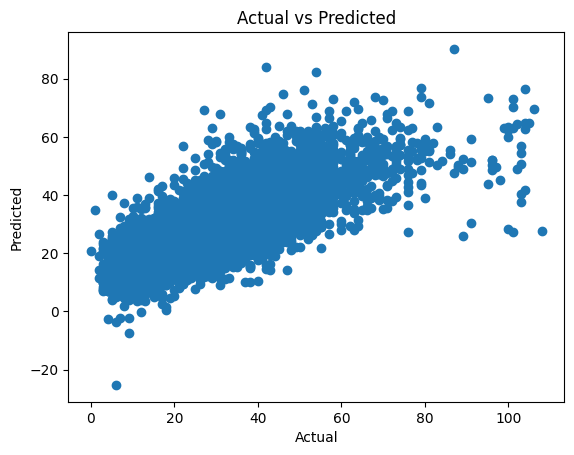

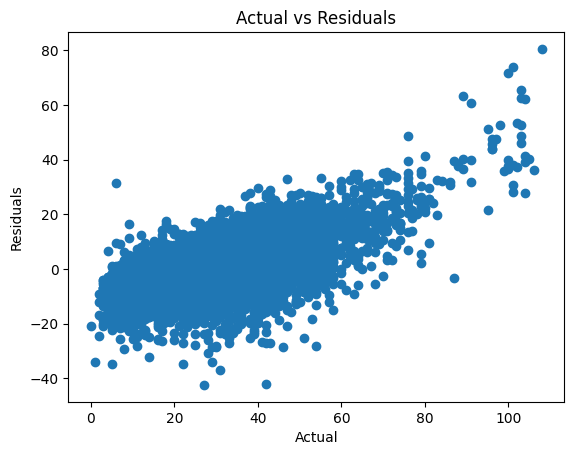

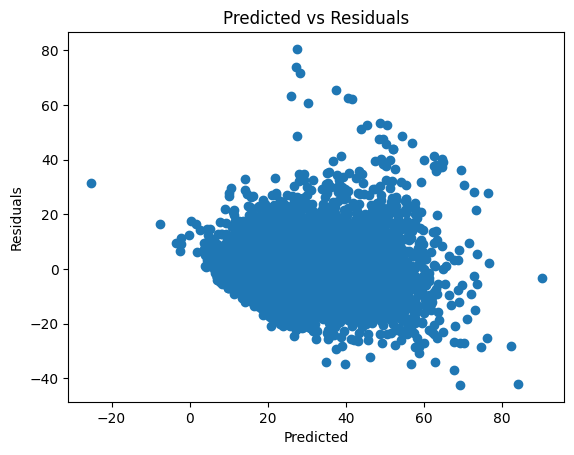

In [57]:
# preform a linear regression on the data to predict the pollution level
topredict = 'NO2 AQI'
model_data = merged_data.copy()

# create a list of numeric columns
numeric_columns = model_data.select_dtypes(include=['float64', 'int64']).columns
# drop WS_Latitude, WS_Longitude from numeric_columns
numeric_columns = numeric_columns.drop(['WS_Latitude', 'WS_Longitude'])
# find related fields to topredict
related_fields = [col for col in model_data.columns if topredict[:3] in col or topredict[:4] in col]
related_numeric_fields = [col for col in related_fields if col in numeric_columns]
# drop related_numeric_fields from numeric_columns
numeric_columns = numeric_columns.drop(related_numeric_fields)
# print topredict and related_fields
print('Column to predict and relatives:', topredict, related_fields, related_numeric_fields)
'output list of numeric columns'
print('Output list of numeric columns:',numeric_columns)

# split data into features and target
X = model_data[numeric_columns]
y = model_data[topredict]

'output shape of X and y'
print(X.shape, y.shape)
# check for missing values in X and y
missing_values_X = X.isna().sum().sum()
missing_values_y = y.isna().sum()
'output missing values in X and y'
print(missing_values_X, missing_values_y)

# print list of fields in X
print(X.columns)

# print list of fields in y
print(y.name)

# print of list of fields in X with missing values
print(X.columns[X.isna().sum() > 0])

# print list of fields in y with missing values
print(y.name, y.isna().sum())


# split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# predict the target using the model
y_pred = model.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("mean square error:",mse)

n = len(y_test)
p = X_test.shape[1]

rss = np.sum((y_test - y_pred) ** 2)
rse = np.sqrt(rss / (n - p - 1))

print("Residual Standard Error (RSE):", rse)
print("Standard deviation of actual NO2 AQI:", y_test.std())
if rse < y_test.std():
    print("The model is better than using the mean value")
else:
    print("The model is not better than using the mean value")


# save the model
import joblib

modelname = f'ML_Models/Linear_Regression_{topredict}_Model_transformed.pkl'
joblib.dump(model, modelname)

# help me understand the mse value
# calculate the mean of the target
y_mean = y.mean()
# calculate the sum of squares
ss_total = ((y - y_mean) ** 2).sum()
# calculate the r squared value
r_squared = 1 - (mse / ss_total)
r_squared

# plot the predicted values against the actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# plot the residuals
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Actual vs Residuals')
plt.show()

# plot the residuals against the predicted values
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs Residuals')
plt.show()


    

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import joblib


def run_pollution_forecast_model(data: pd.DataFrame, topredict: str, model_save_path: str = None):
    print(f"\n🚀 Running model for: {topredict}")

    # Step 1: Identify numeric features and remove coordinates
    numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns.tolist()
    for col in ['WS_Latitude', 'WS_Longitude']:
        if col in numeric_columns:
            numeric_columns.remove(col)

    # Step 2: Remove features directly related to the pollutant
    target_prefix = topredict.split()[0].lower()
    related_fields = [col for col in data.columns if col.lower().startswith(target_prefix)]
    related_numeric_fields = [col for col in related_fields if col in numeric_columns]

    print(f"🧹 Dropping related pollutant features: {related_numeric_fields}")
    feature_columns = [col for col in numeric_columns if col not in related_numeric_fields]

    # Step 3: Create feature and target sets
    Xt = data[feature_columns].copy()
    yt = data[topredict].copy()

    # Handle missing values
    Xt = Xt.dropna()
    yt = yt.loc[Xt.index]
    
    print(f"✅ Input shape: {Xt.shape}, Target shape: {yt.shape}")

    # Step 4: Scale features
    scaler = StandardScaler()
    Xt_scaled = scaler.fit_transform(Xt)

    # Step 5: Split data
    X_train, X_test, y_train, y_test = train_test_split(Xt_scaled, yt, test_size=0.2, random_state=42)

    # Step 6: Fit Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Step 7: Evaluate performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"📉 Mean Squared Error: {mse:.2f}")
    print(f"📈 R² Score: {r2:.4f}")

    # Optional: Save the model
    if model_save_path:
        joblib.dump(model, model_save_path)
        print(f"💾 Model saved to: {model_save_path}")

    # Step 8: Visualizations
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted: {topredict}")
    plt.grid(True)
    plt.show()

    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, residuals, alpha=0.6)
    plt.xlabel("Actual")
    plt.ylabel("Residuals")
    plt.title("Actual vs Residuals")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Predicted vs Residuals")
    plt.grid(True)
    plt.show()

    # Step 9: Feature importance test (optional)
    selector = SelectKBest(score_func=f_regression, k="all")
    selector.fit(Xt_scaled, yt)
    scores = pd.Series(selector.scores_, index=feature_columns).sort_values(ascending=False)

    print("\n📊 Feature importance (F-scores):")
    print(scores.round(2))



🚀 Running model for: NO2 AQI
🧹 Dropping related pollutant features: ['NO2 Mean', 'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI', 'NO2_AQI_Group']
✅ Input shape: (46054, 43), Target shape: (46054,)
📉 Mean Squared Error: 90.27
📈 R² Score: 0.5716
💾 Model saved to: ML_Models/NO2_AQI_Model.pkl


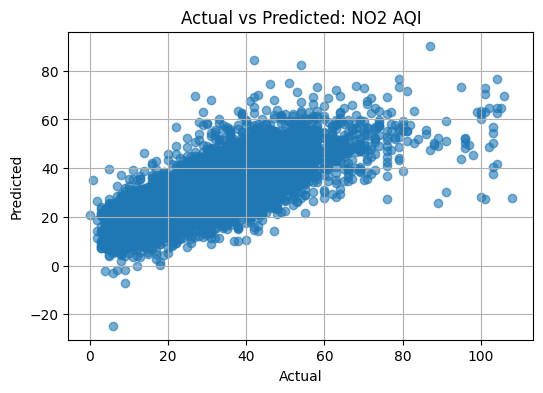

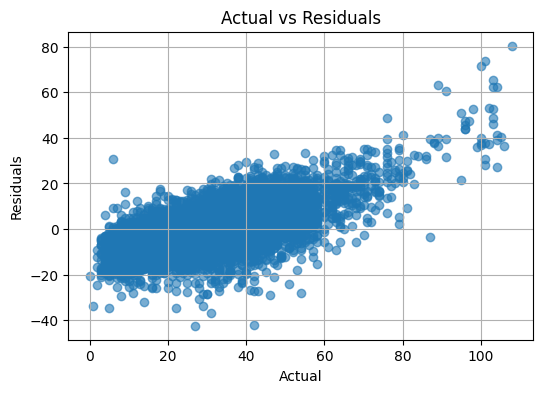

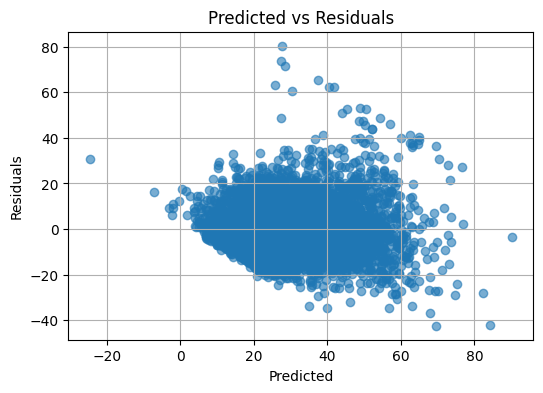


📊 Feature importance (F-scores):
CO AQI               22563.47
CO 1st Max Value     22344.74
CO Mean              12327.61
SO2 Mean              4708.18
SO2 AQI               4305.03
SO2 1st Max Value     4051.69
O3 Mean               3329.88
CO 1st Max Hour       3009.47
Year                  2047.90
year                  2047.90
AWND                  1857.82
Site Num              1785.14
PGTM                  1251.68
SO2 1st Max Hour      1070.92
County Code            750.28
TAVG                   374.37
O3_AQI_Group           365.00
WT13                   362.52
WT16                   329.16
State Code             323.12
WT01                   290.45
TMIN                   259.49
WDMV                   236.96
CityDistance           236.11
SO2_AQI_Group          197.90
WT08                   131.02
WT02                   123.83
PRCP                   100.68
O3 1st Max Hour         89.74
TMAX                    68.89
WS_Elevation            65.03
CO_AQI_Group            44.69
WT03  

In [62]:
# Example usage:
run_pollution_forecast_model(merged_data, topredict="NO2 AQI", model_save_path="ML_Models/NO2_AQI_Model.pkl")



🚀 Running model for: O3 AQI
🧹 Dropping related pollutant features: ['O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'O3_AQI_Group']
✅ Input shape: (46054, 43), Target shape: (46054,)
📉 Mean Squared Error: 226.09
📈 R² Score: 0.2592
💾 Model saved to: ML_Models/O3_AQI_Model.pkl


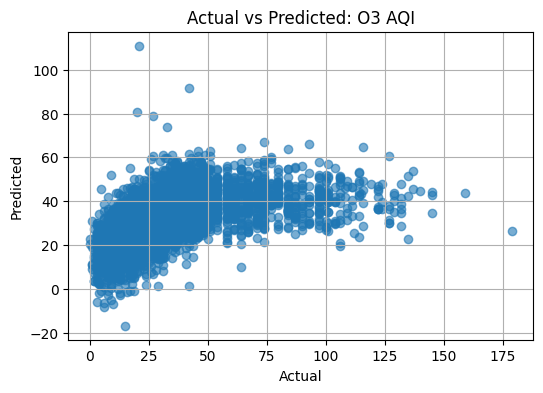

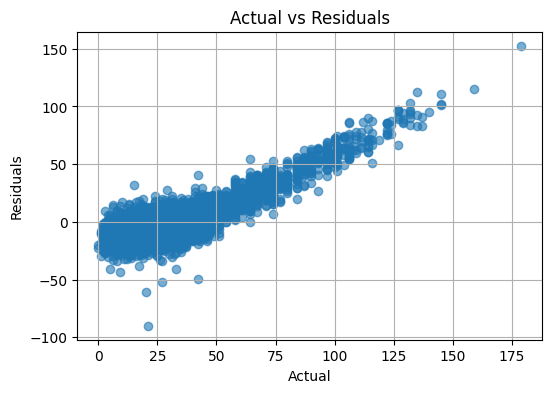

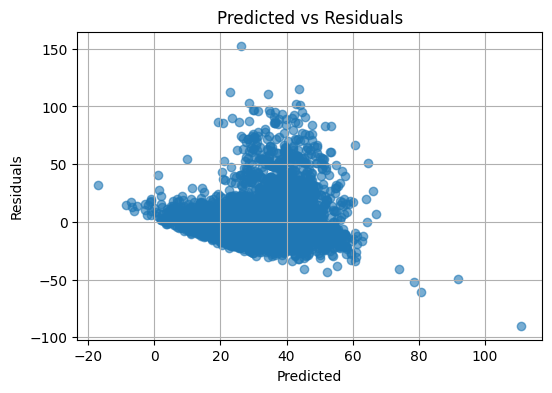


📊 Feature importance (F-scores):
TMIN                 2020.87
NO2 Mean             1439.98
CO 1st Max Value     1172.58
CO AQI               1135.58
CityDistance          875.53
CO Mean               809.69
TMAX                  525.02
NO2 1st Max Hour      471.51
CO 1st Max Hour       427.30
SO2 Mean              307.22
TAVG                  302.39
Site Num              136.10
PGTM                   69.15
State Code             67.53
WT01                   50.92
WT18                   49.36
SO2 1st Max Value      40.47
SO2 AQI                37.54
NO2_AQI_Group          32.87
SO2 1st Max Hour       31.55
WT03                   30.65
WT22                   21.25
WT06                   20.86
AWND                   15.74
Year                   15.22
year                   15.22
NO2 AQI                14.56
NO2 1st Max Value      14.47
WT04                   11.92
WT09                    7.23
WT02                    6.40
CO_AQI_Group            4.56
WT16                    3.51
PRCP     

In [63]:
# Example usage:
run_pollution_forecast_model(merged_data, topredict="O3 AQI", model_save_path="ML_Models/O3_AQI_Model.pkl")



🚀 Running model for: CO AQI
🧹 Dropping related pollutant features: ['County Code', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI', 'CO_AQI_Group']
✅ Input shape: (46054, 42), Target shape: (46054,)
📉 Mean Squared Error: 14.90
📈 R² Score: 0.5152
💾 Model saved to: ML_Models/CO_AQI_Model.pkl


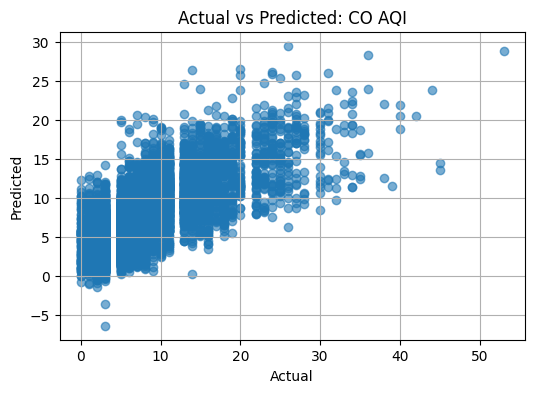

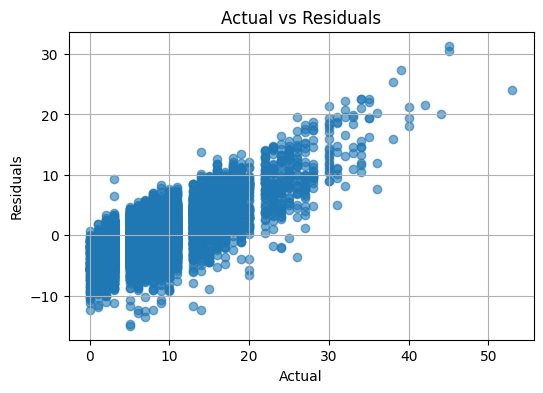

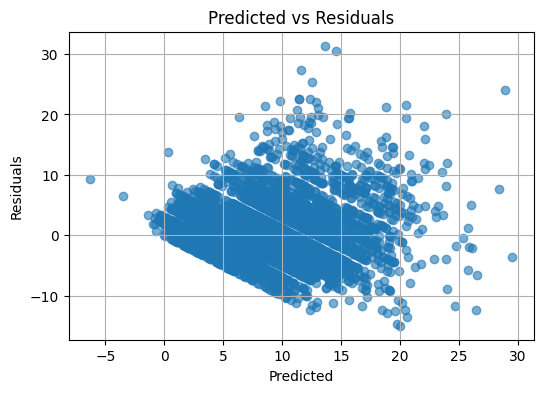


📊 Feature importance (F-scores):
NO2 Mean             30726.63
NO2 AQI              22563.47
NO2 1st Max Value    22257.67
NO2_AQI_Group        10058.28
O3 Mean               6311.81
SO2 Mean              4546.48
year                  3639.97
Year                  3639.97
State Code            3574.66
SO2 AQI               2894.74
SO2 1st Max Value     2619.17
O3 1st Max Value      1891.12
Site Num              1646.61
TMIN                  1139.92
O3 AQI                1135.58
WS_Elevation          1108.47
TMAX                   271.56
SO2 1st Max Hour       249.00
SO2_AQI_Group           93.87
AWND                    90.57
PRCP                    82.76
WDMV                    67.78
PGTM                    59.65
O3 1st Max Hour         51.62
WT16                    34.32
NO2 1st Max Hour        22.69
O3_AQI_Group            17.65
WT06                    16.91
WT13                    16.45
WT18                    14.62
WT05                     8.98
WT22                     8.30
TAVG  

In [64]:
# Example usage:
run_pollution_forecast_model(merged_data, topredict="CO AQI", model_save_path="ML_Models/CO_AQI_Model.pkl")



🚀 Running model for: SO2 AQI
🧹 Dropping related pollutant features: ['SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI', 'SO2_AQI_Group']
✅ Input shape: (46054, 43), Target shape: (46054,)
📉 Mean Squared Error: 74.89
📈 R² Score: 0.2623
💾 Model saved to: ML_Models/SO2_AQI_Model.pkl


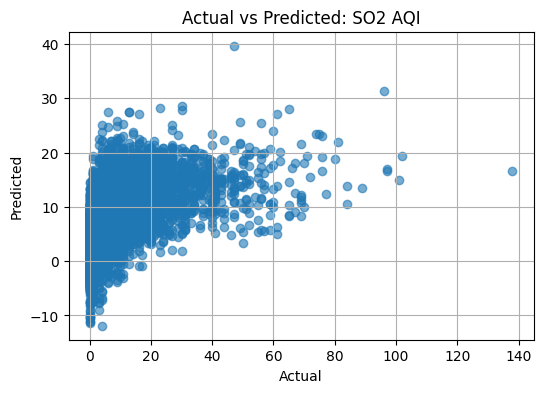

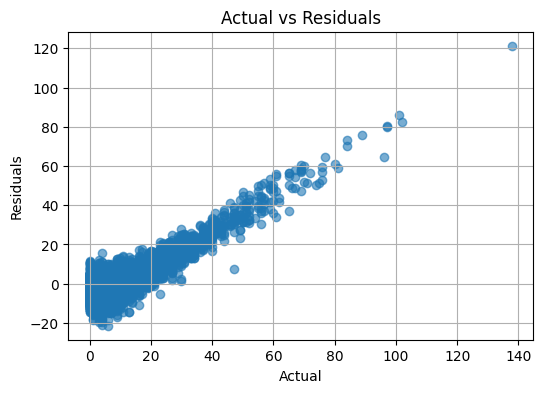

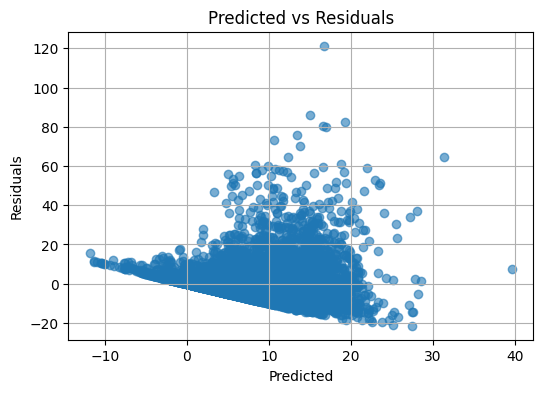


📊 Feature importance (F-scores):
NO2 Mean             4726.19
year                 4533.18
Year                 4533.18
NO2 AQI              4305.03
NO2 1st Max Value    4259.62
CO AQI               2894.74
CO Mean              2894.07
CO 1st Max Value     2874.93
Site Num              945.50
CityDistance          871.62
NO2_AQI_Group         792.24
O3 Mean               585.04
WS_Elevation          371.64
CO 1st Max Hour       359.73
State Code            249.96
TMIN                  249.02
O3 1st Max Value      197.01
O3_AQI_Group          152.03
WT13                   94.89
O3 1st Max Hour        83.07
WT16                   62.76
WT08                   44.60
WDMV                   44.32
O3 AQI                 37.54
WT18                   29.19
TAVG                   28.57
CO_AQI_Group           26.70
County Code            24.42
TMAX                   23.33
WT05                   21.36
WT02                   15.18
WT06                   13.91
PRCP                   12.87
WT04     

In [65]:
# Example usage:
run_pollution_forecast_model(merged_data, topredict="SO2 AQI", model_save_path="ML_Models/SO2_AQI_Model.pkl")


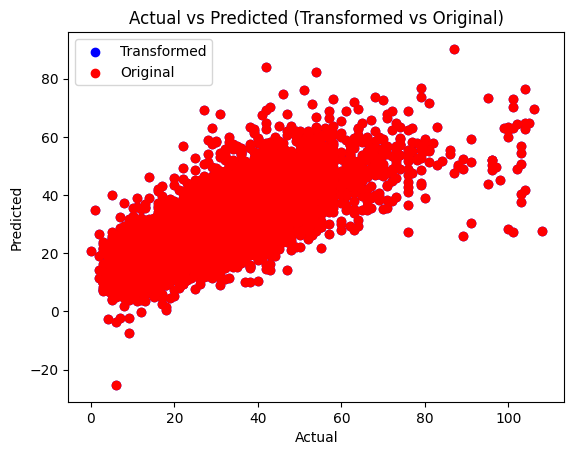

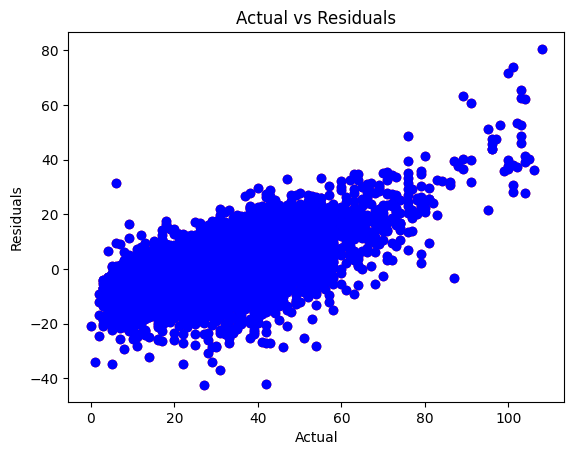

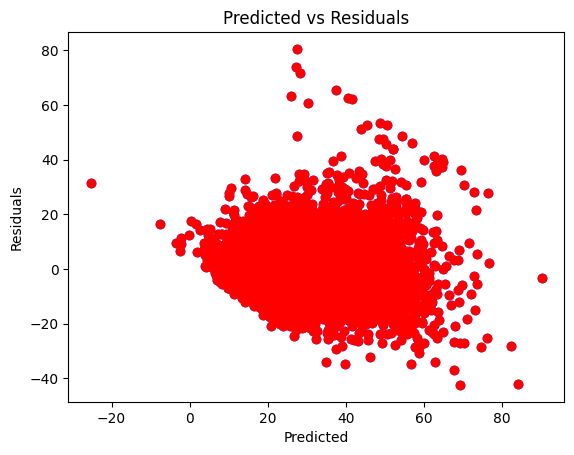

In [ ]:
# produce graphs which overlay the model predicitions prior and post transformation using the output from above

# plot the predicted values against the actual values for Transformed and Original on the same plot
plt.scatter(yt_test, yt_pred, color='blue', label='Transformed')
plt.scatter(y_test, y_pred, color='red', label='Original')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Transformed vs Original)')
plt.legend()
plt.show()

# plot the residuals
t_residuals = yt_test - yt_pred
residuals = y_test - y_pred
plt.scatter(y_test, residuals, color='red', label='Original')
plt.scatter(yt_test, t_residuals, color='blue', label='Transformed')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Actual vs Residuals')
plt.legend()
plt.show()

# plot the residuals against the predicted values
plt.scatter(yt_pred, t_residuals, color='blue', label='Transformed')
plt.scatter(y_pred, residuals, color='red', label='Original')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs Residuals')
plt.legend()
plt.show()


Load model and predict


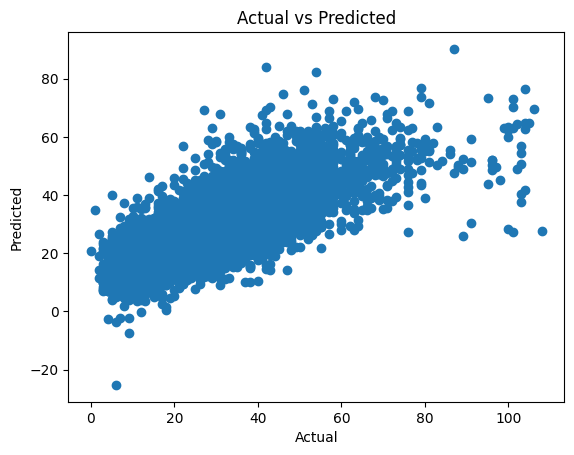

In [25]:
# load the model
model = joblib.load('Outputs/Linear_Regression_Model.pkl')

# predict the target using the model
y_pred = model.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
mse

# create a dataframe of the coefficients
coefficients = pd.DataFrame(model.coef_, index=numeric_columns, columns=['Coefficient'])
coefficients

# create a dataframe of the intercept
intercept = pd.DataFrame([model.intercept_], index=['Intercept'], columns=['Value'])
intercept

# save the coefficients and intercept to csv
coefficients.to_csv('Outputs/Coefficients.csv')
intercept.to_csv('Outputs/Intercept.csv')

# help me understand the outputs of the model
# calculate the mean of the target
y_mean = y.mean()
# calculate the sum of squares
ss_total = ((y - y_mean) ** 2).sum()

# calculate the r squared value
r_squared = 1 - (mse / ss_total)
r_squared

# plot the predicted values against the actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


def run_pollution_forecast_with_comparison(data: pd.DataFrame, topredict: str, model_save_path: str = None):
    print(f"\n🚀 Running model comparison for: {topredict}")

    # Step 1: Setup & field filtering
    numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns.tolist()
    for col in ['WS_Latitude', 'WS_Longitude']:
        if col in numeric_columns:
            numeric_columns.remove(col)

    target_prefix = topredict.split()[0].lower()
    related_fields = [col for col in data.columns if col.lower().startswith(target_prefix)]
    related_numeric_fields = [col for col in related_fields if col in numeric_columns]
    feature_columns = [col for col in numeric_columns if col not in related_numeric_fields]

    print(f"🧹 Dropping related fields: {related_numeric_fields}")
    Xt = data[feature_columns].copy()
    yt = data[topredict].copy()

    Xt = Xt.dropna()
    yt = yt.loc[Xt.index]

    # Step 2: Scale features
    scaler = StandardScaler()
    Xt_scaled = scaler.fit_transform(Xt)

    # Step 3: Split data
    X_train, X_test, y_train, y_test = train_test_split(Xt_scaled, yt, test_size=0.2, random_state=42)

    # Step 4: Define models to test
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.append({
            "Model": name,
            "MSE": mse,
            "R2": r2,
            "Predictions": y_pred,
            "Residuals": y_test - y_pred,
            "FittedModel": model
        })

        print(f"\n📊 {name}")
        print(f"  - MSE: {mse:.2f}")
        print(f"  - R²: {r2:.4f}")

        # Plot residuals
        plt.figure(figsize=(6, 4))
        plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
        plt.axhline(0, color="red", linestyle="--")
        plt.xlabel("Predicted")
        plt.ylabel("Residuals")
        plt.title(f"{name} - Predicted vs Residuals")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Step 5: Feature importance (based on Linear Regression)
    selector = SelectKBest(score_func=f_regression, k="all")
    selector.fit(Xt_scaled, yt)
    scores = pd.Series(selector.scores_, index=feature_columns).sort_values(ascending=False)

    print("\n📈 Feature importance (F-score, not model-specific):")
    print(scores.round(2))

    # Step 6: Save best model if requested
    if model_save_path:
        best_model = max(results, key=lambda x: x["R2"])
        joblib.dump(best_model["FittedModel"], model_save_path)
        print(f"\n💾 Best model ({best_model['Model']}) saved to: {model_save_path}")

    return results  # optional: return results if you want to use them later


🚀 Running model comparison for: NO2 AQI
🧹 Dropping related fields: ['NO2 Mean', 'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI', 'NO2_AQI_Group']

📊 Linear Regression
  - MSE: 90.27
  - R²: 0.5716


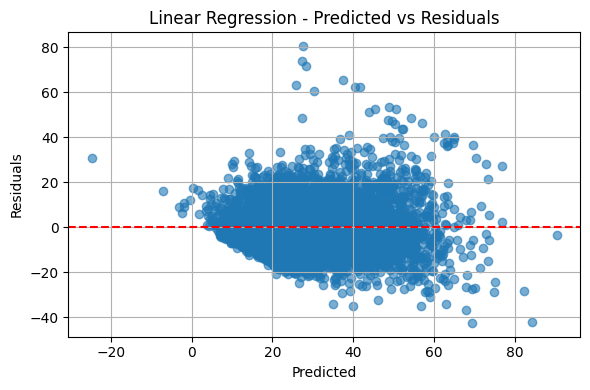


📊 Random Forest
  - MSE: 64.90
  - R²: 0.6920


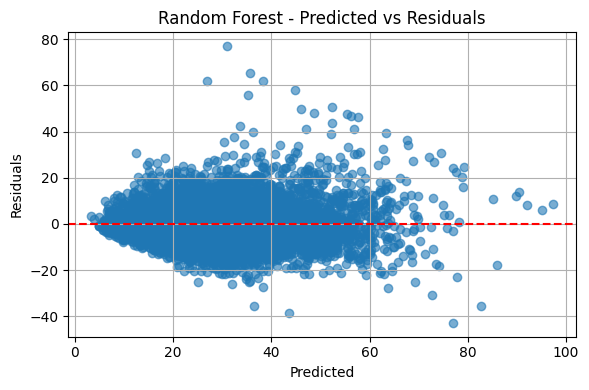


📊 Gradient Boosting
  - MSE: 72.66
  - R²: 0.6551


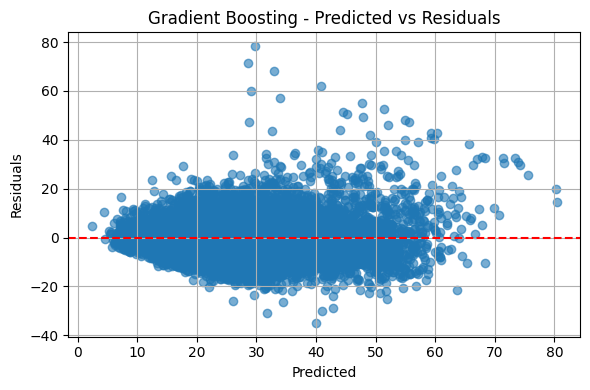


📈 Feature importance (F-score, not model-specific):
CO AQI               22563.47
CO 1st Max Value     22344.74
CO Mean              12327.61
SO2 Mean              4708.18
SO2 AQI               4305.03
SO2 1st Max Value     4051.69
O3 Mean               3329.88
CO 1st Max Hour       3009.47
Year                  2047.90
year                  2047.90
AWND                  1857.82
Site Num              1785.14
PGTM                  1251.68
SO2 1st Max Hour      1070.92
County Code            750.28
TAVG                   374.37
O3_AQI_Group           365.00
WT13                   362.52
WT16                   329.16
State Code             323.12
WT01                   290.45
TMIN                   259.49
WDMV                   236.96
CityDistance           236.11
SO2_AQI_Group          197.90
WT08                   131.02
WT02                   123.83
PRCP                   100.68
O3 1st Max Hour         89.74
TMAX                    68.89
WS_Elevation            65.03
CO_AQI_Group     

[{'Model': 'Linear Regression',
  'MSE': 90.26867862100552,
  'R2': 0.5715666499950615,
  'Predictions': array([56.17407964, 25.79517339, 15.86548589, ..., 21.99048589,
         54.16236089, 21.47876714]),
  'Residuals': 17160   -14.174080
  19705    14.204827
  38352    -6.865486
  31687     5.435295
  19962     4.350334
             ...    
  32629     8.294670
  31178     0.868889
  12257   -13.990486
  268      31.837639
  3142     -1.478767
  Name: NO2 AQI, Length: 9211, dtype: float64,
  'FittedModel': LinearRegression()},
 {'Model': 'Random Forest',
  'MSE': 64.89523957225057,
  'R2': 0.6919941078782719,
  'Predictions': array([52.43, 26.58, 15.13, ..., 19.87, 67.45, 21.82]),
  'Residuals': 17160   -10.43
  19705    13.42
  38352    -6.13
  31687     6.58
  19962    -0.92
           ...  
  32629     6.00
  31178     1.91
  12257   -11.87
  268      18.55
  3142     -1.82
  Name: NO2 AQI, Length: 9211, dtype: float64,
  'FittedModel': RandomForestRegressor(random_state=42)},
 {'

In [67]:
run_pollution_forecast_with_comparison(
    data=merged_data,
    topredict="NO2 AQI",
    model_save_path="ML_Models/best_model_NO2.pkl"
)


🚀 Running model comparison for: O3 AQI
🧹 Dropping related fields: ['O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'O3_AQI_Group']

📊 Linear Regression
  - MSE: 226.09
  - R²: 0.2592


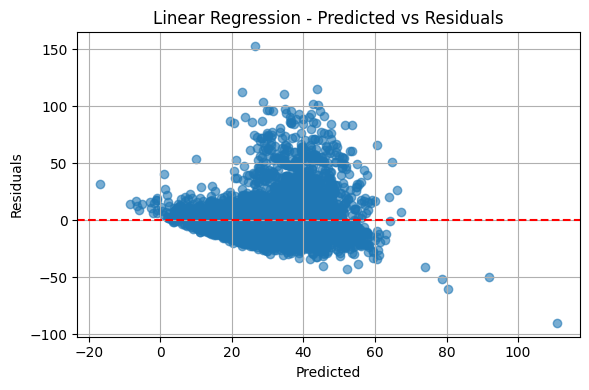


📊 Random Forest
  - MSE: 170.03
  - R²: 0.4429


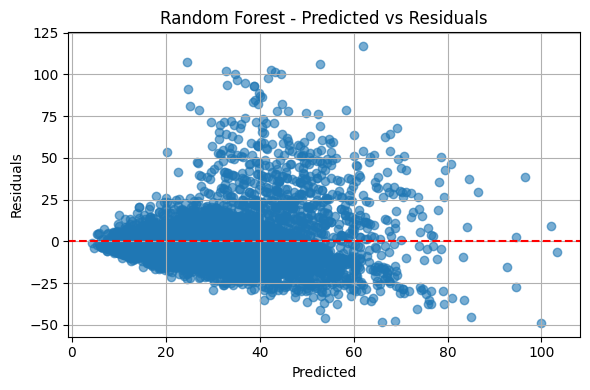


📊 Gradient Boosting
  - MSE: 190.39
  - R²: 0.3762


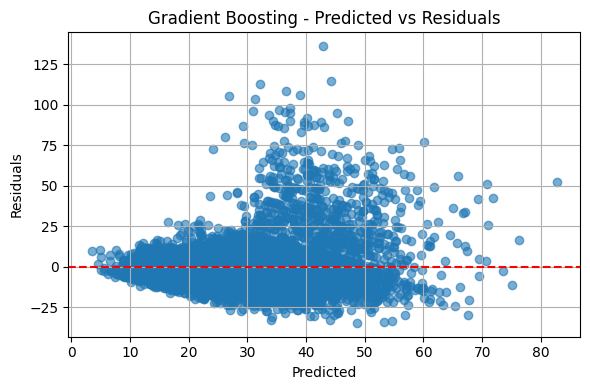


📈 Feature importance (F-score, not model-specific):
TMIN                 2020.87
NO2 Mean             1439.98
CO 1st Max Value     1172.58
CO AQI               1135.58
CityDistance          875.53
CO Mean               809.69
TMAX                  525.02
NO2 1st Max Hour      471.51
CO 1st Max Hour       427.30
SO2 Mean              307.22
TAVG                  302.39
Site Num              136.10
PGTM                   69.15
State Code             67.53
WT01                   50.92
WT18                   49.36
SO2 1st Max Value      40.47
SO2 AQI                37.54
NO2_AQI_Group          32.87
SO2 1st Max Hour       31.55
WT03                   30.65
WT22                   21.25
WT06                   20.86
AWND                   15.74
Year                   15.22
year                   15.22
NO2 AQI                14.56
NO2 1st Max Value      14.47
WT04                   11.92
WT09                    7.23
WT02                    6.40
CO_AQI_Group            4.56
WT16               

[{'Model': 'Linear Regression',
  'MSE': 226.08947343338926,
  'R2': 0.25923876858117656,
  'Predictions': array([21.88561354, 29.72706519, 27.43420123, ..., 33.78795171,
         24.59690767, 41.46556382]),
  'Residuals': 17160     5.114386
  19705   -10.727065
  38352     8.565799
  31687    -4.767968
  19962    -4.760403
             ...    
  32629    -3.356599
  31178    -2.553627
  12257     0.212048
  268     -18.596908
  3142    -16.465564
  Name: O3 AQI, Length: 9211, dtype: float64,
  'FittedModel': LinearRegression()},
 {'Model': 'Random Forest',
  'MSE': 170.02513894256867,
  'R2': 0.4429283708674714,
  'Predictions': array([18.31, 31.35, 27.54, ..., 35.11,  7.53, 29.74]),
  'Residuals': 17160     8.69
  19705   -12.35
  38352     8.46
  31687     2.43
  19962    -2.89
           ...  
  32629    -1.75
  31178    -1.67
  12257    -1.11
  268      -1.53
  3142     -4.74
  Name: O3 AQI, Length: 9211, dtype: float64,
  'FittedModel': RandomForestRegressor(random_state=42)},
 {

In [68]:
run_pollution_forecast_with_comparison(
    data=merged_data,
    topredict="O3 AQI",
    model_save_path="ML_Models/best_model_O3.pkl"
)


🚀 Running model comparison for: CO AQI
🧹 Dropping related fields: ['County Code', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI', 'CO_AQI_Group']

📊 Linear Regression
  - MSE: 14.90
  - R²: 0.5152


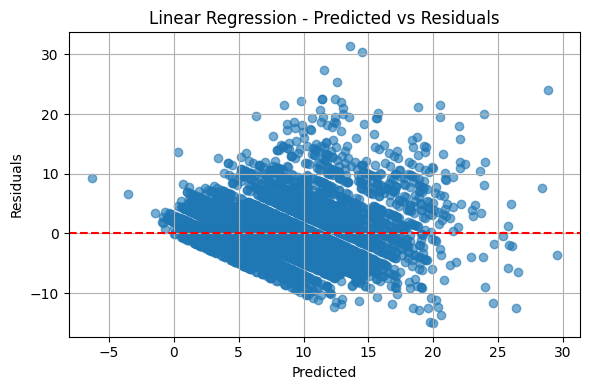


📊 Random Forest
  - MSE: 9.55
  - R²: 0.6893


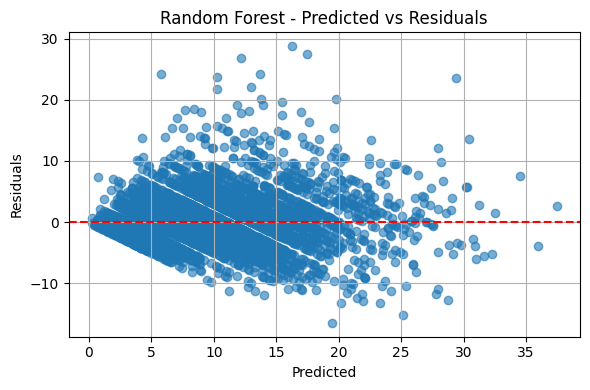


📊 Gradient Boosting
  - MSE: 10.99
  - R²: 0.6423


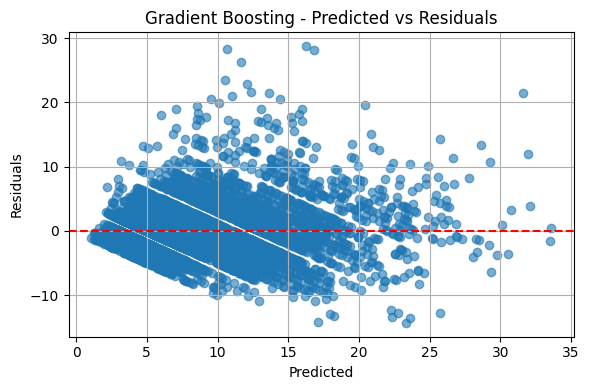


📈 Feature importance (F-score, not model-specific):
NO2 Mean             30726.63
NO2 AQI              22563.47
NO2 1st Max Value    22257.67
NO2_AQI_Group        10058.28
O3 Mean               6311.81
SO2 Mean              4546.48
year                  3639.97
Year                  3639.97
State Code            3574.66
SO2 AQI               2894.74
SO2 1st Max Value     2619.17
O3 1st Max Value      1891.12
Site Num              1646.61
TMIN                  1139.92
O3 AQI                1135.58
WS_Elevation          1108.47
TMAX                   271.56
SO2 1st Max Hour       249.00
SO2_AQI_Group           93.87
AWND                    90.57
PRCP                    82.76
WDMV                    67.78
PGTM                    59.65
O3 1st Max Hour         51.62
WT16                    34.32
NO2 1st Max Hour        22.69
O3_AQI_Group            17.65
WT06                    16.91
WT13                    16.45
WT18                    14.62
WT05                     8.98
WT22             

[{'Model': 'Linear Regression',
  'MSE': 14.896974763230558,
  'R2': 0.5152053720534049,
  'Predictions': array([14.36481349,  7.8918601 ,  0.60345716, ...,  4.13473315,
         22.0525546 ,  7.25629261]),
  'Residuals': 17160     4.635187
  19705    -4.891860
  38352     1.396543
  31687     0.569090
  19962    -3.374575
             ...    
  32629    -3.410144
  31178    -4.549063
  12257     5.865267
  268      11.947445
  3142     -1.256293
  Name: CO AQI, Length: 9211, dtype: float64,
  'FittedModel': LinearRegression()},
 {'Model': 'Random Forest',
  'MSE': 9.547969156443383,
  'R2': 0.6892789154568095,
  'Predictions': array([17.52,  5.18,  1.88, ...,  6.38, 32.47,  7.03]),
  'Residuals': 17160    1.48
  19705   -2.18
  38352    0.12
  31687   -3.07
  19962   -0.87
           ... 
  32629    0.42
  31178   -0.93
  12257    3.62
  268      1.53
  3142    -1.03
  Name: CO AQI, Length: 9211, dtype: float64,
  'FittedModel': RandomForestRegressor(random_state=42)},
 {'Model': 'Gra

In [69]:
run_pollution_forecast_with_comparison(
    data=merged_data,
    topredict="CO AQI",
    model_save_path="ML_Models/best_model_CO.pkl"
)